In [ ]:
import sys
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append('../../')

import numpy as np
import random
from IPython.display import Image

import torch
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10

from utils import show_first_batch, transform_data, show_images, plot_metrics_iddpm, show_tensor_images, calculate_metrics
from train import Trainer
from diffusion_models.ddpm_classifier_free_guidance import GaussianDiffusion
from metrics.fid_score import fid_score
from metrics.inception_score import inception_score
from diffusion_models.iddpm import Classifier, classifier_cond_fn

from diffusion_models.ddpm_classifier_free_guidance import Unet

import ipywidgets as widgets
widgets.IntSlider()

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Files already downloaded and verified


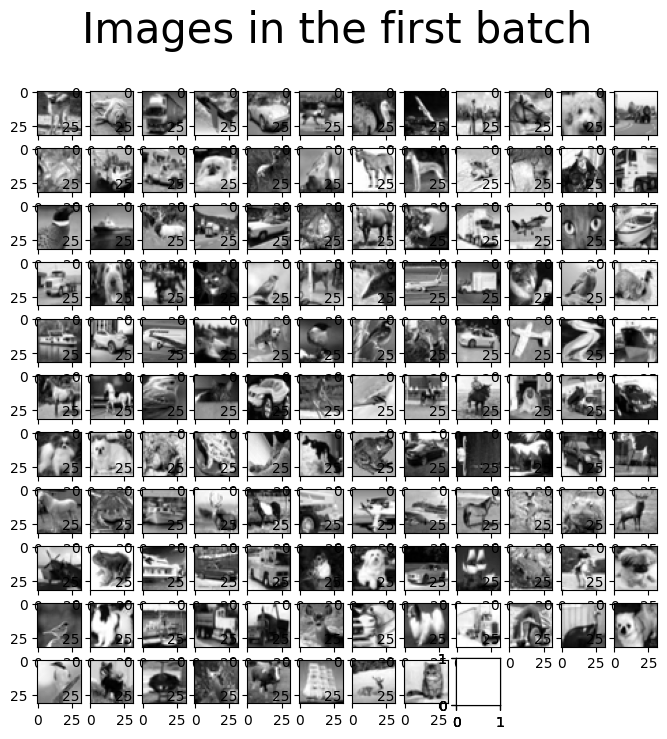

In [2]:
dataset = transform_data(CIFAR10, store_path="../../datasets")
train_dataloader = DataLoader(dataset, batch_size=128, num_workers=0, shuffle=True)
show_first_batch(train_dataloader)

In [3]:
num_classes = 10

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    num_classes = num_classes,
    cond_drop_prob = 0.5
)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000
).cuda()


In [9]:
trainer = Trainer(
    diffusion,
    train_dataloader,
    train_lr = 2e-4,
    train_num_steps = 700000, 
    device=device
) 

In [ ]:
trainer.train_guidance_free()

In [14]:
store_path = '../../model_weights/iddpm_cifar_steps_1000_guidance_free.pt'
torch.save(diffusion.state_dict(), store_path)

In [15]:
store_path = '../../model_weights/iddpm_cifar_steps_1000_guidance_free.pt'

num_classes = 10

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    num_classes = num_classes,
    cond_drop_prob = 0.5
)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000
).cuda()



diffusion.load_state_dict(torch.load(store_path, map_location=device))
diffusion.eval()
print('Model loaded')

Model loaded


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

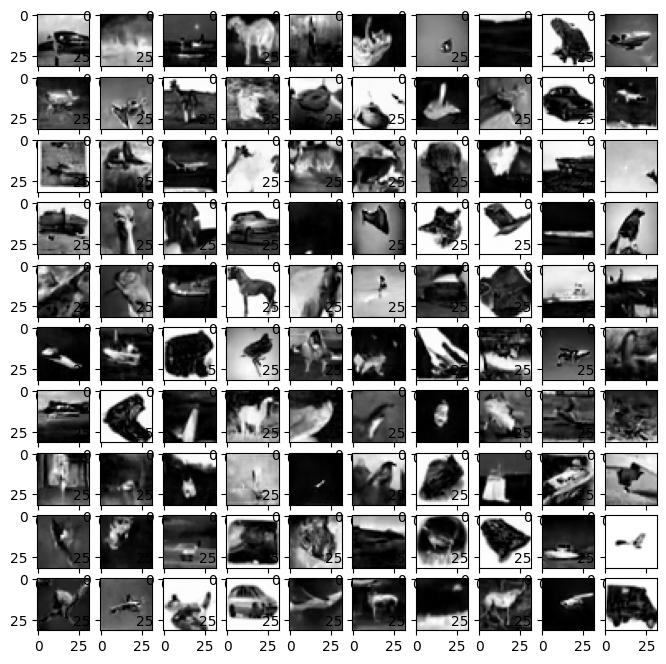

In [16]:
batch_size = 100
image_classes = torch.randint(0, num_classes, (batch_size,)).cuda()


sampled_images = diffusion.sample(
        classes = image_classes,
        cond_scale = 3.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
)

show_images(sampled_images)

In [17]:
device = torch.device('cpu')
real_images = next(iter(DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)))[0].to(device)

inception_score, fid_score = calculate_metrics(sampled_images, real_images, device)
print('inception_score = {}, fid_score = {}'.format(inception_score, fid_score))

inception_score = 3.160595393944088, fid_score = 184.52738043942492
